# Sentiment Analysis of Amazon's customer reviews

**Author**: Goundo Sidibe /
**Sources**: https://github.com/Gsidi9/AmazonReview/blob/main/amazon_reviews%20(1).csv

## Importing the packages

In [1]:
# ! pip install plotly
# ! pip install cufflinks

In [2]:
# General packages
import pandas as pd
import numpy as np


# # NLP packages
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import time 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import plotly.graph_objects as go
import re

We will be working with a .csv file that contains information of 580 customers writing reviews on Amazon audible membership. Each review contains textual feedback along with a 1-to-5 star rating system (1 being least satisfied and 5 being most satisfied). The following attributes are available in the data:

1. **customer (text):** register user profile name.
2. **Score (ordinal):** rating between 1 and 5.
3. **Time (numerical):** timestamp of the review.
4. **title (text):** title of the review.
5. **Text (text):** text of the review.

## Reading and performing basic analysis of the data

In [3]:
df = pd.read_csv('https://media.githubusercontent.com/media/juliandariomirandacalle/NLP_Notebooks/master/01-Introduction_NLP/Customer_Reviews.csv')
df.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data Exploratory

In [4]:
#look at the distribution of ratings
percent_val = 100 * df['Score'].value_counts()/len(df)
percent_val

5    61.83
4    14.33
1     9.32
3     8.62
2     5.90
Name: Score, dtype: float64

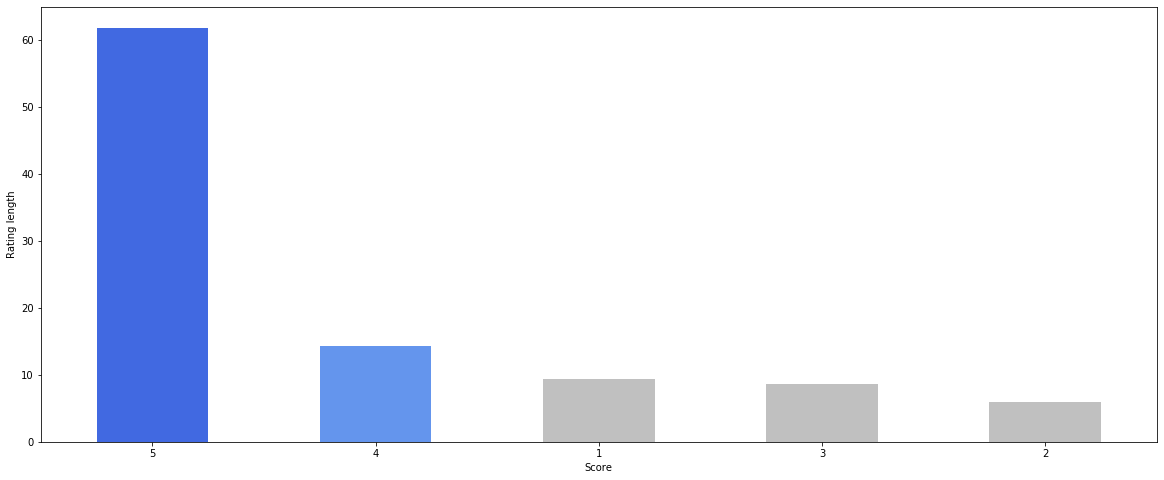

In [5]:
percent_val.plot.bar(figsize=(20,8), color=['royalblue','cornflowerblue','silver','silver','silver'])
plt.ylabel('Rating length')
plt.xticks(rotation=0,horizontalalignment="center")
plt.xlabel('Score')
plt.show()

### Standardizing the ratings for sentiment analysis

In [6]:
#convert all of the ratings into binary values using the follow rule.
# ratings of 4 or 5 will be mapped to 1 and will be reltead to positive reviews.
#ratings of 1 or 2 will get mapped to 0 and will be related to negative reviews.
#ratings of 3 will get removed since they will represent neutral reviews.
# Mapping the ratings


sentences = df['Text']

# Mapping the ratings
df['labels'] = np.where(df.Score > 3,1,0)

#Removing neutral reviews 
df= df[df.Text != 3]

# Printing the counts of each class
df['labels'].value_counts()


1    7616
0    2384
Name: labels, dtype: int64

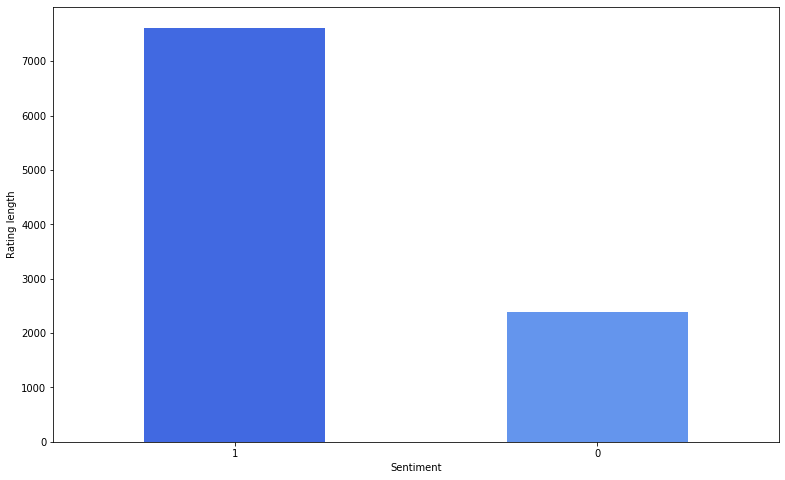

In [7]:
df.labels.value_counts().plot.bar(figsize=(13,8),color=['royalblue','cornflowerblue'])
plt.ylabel('Rating length')
plt.xticks(rotation=0,horizontalalignment="center")
plt.xlabel('Sentiment')
plt.show()

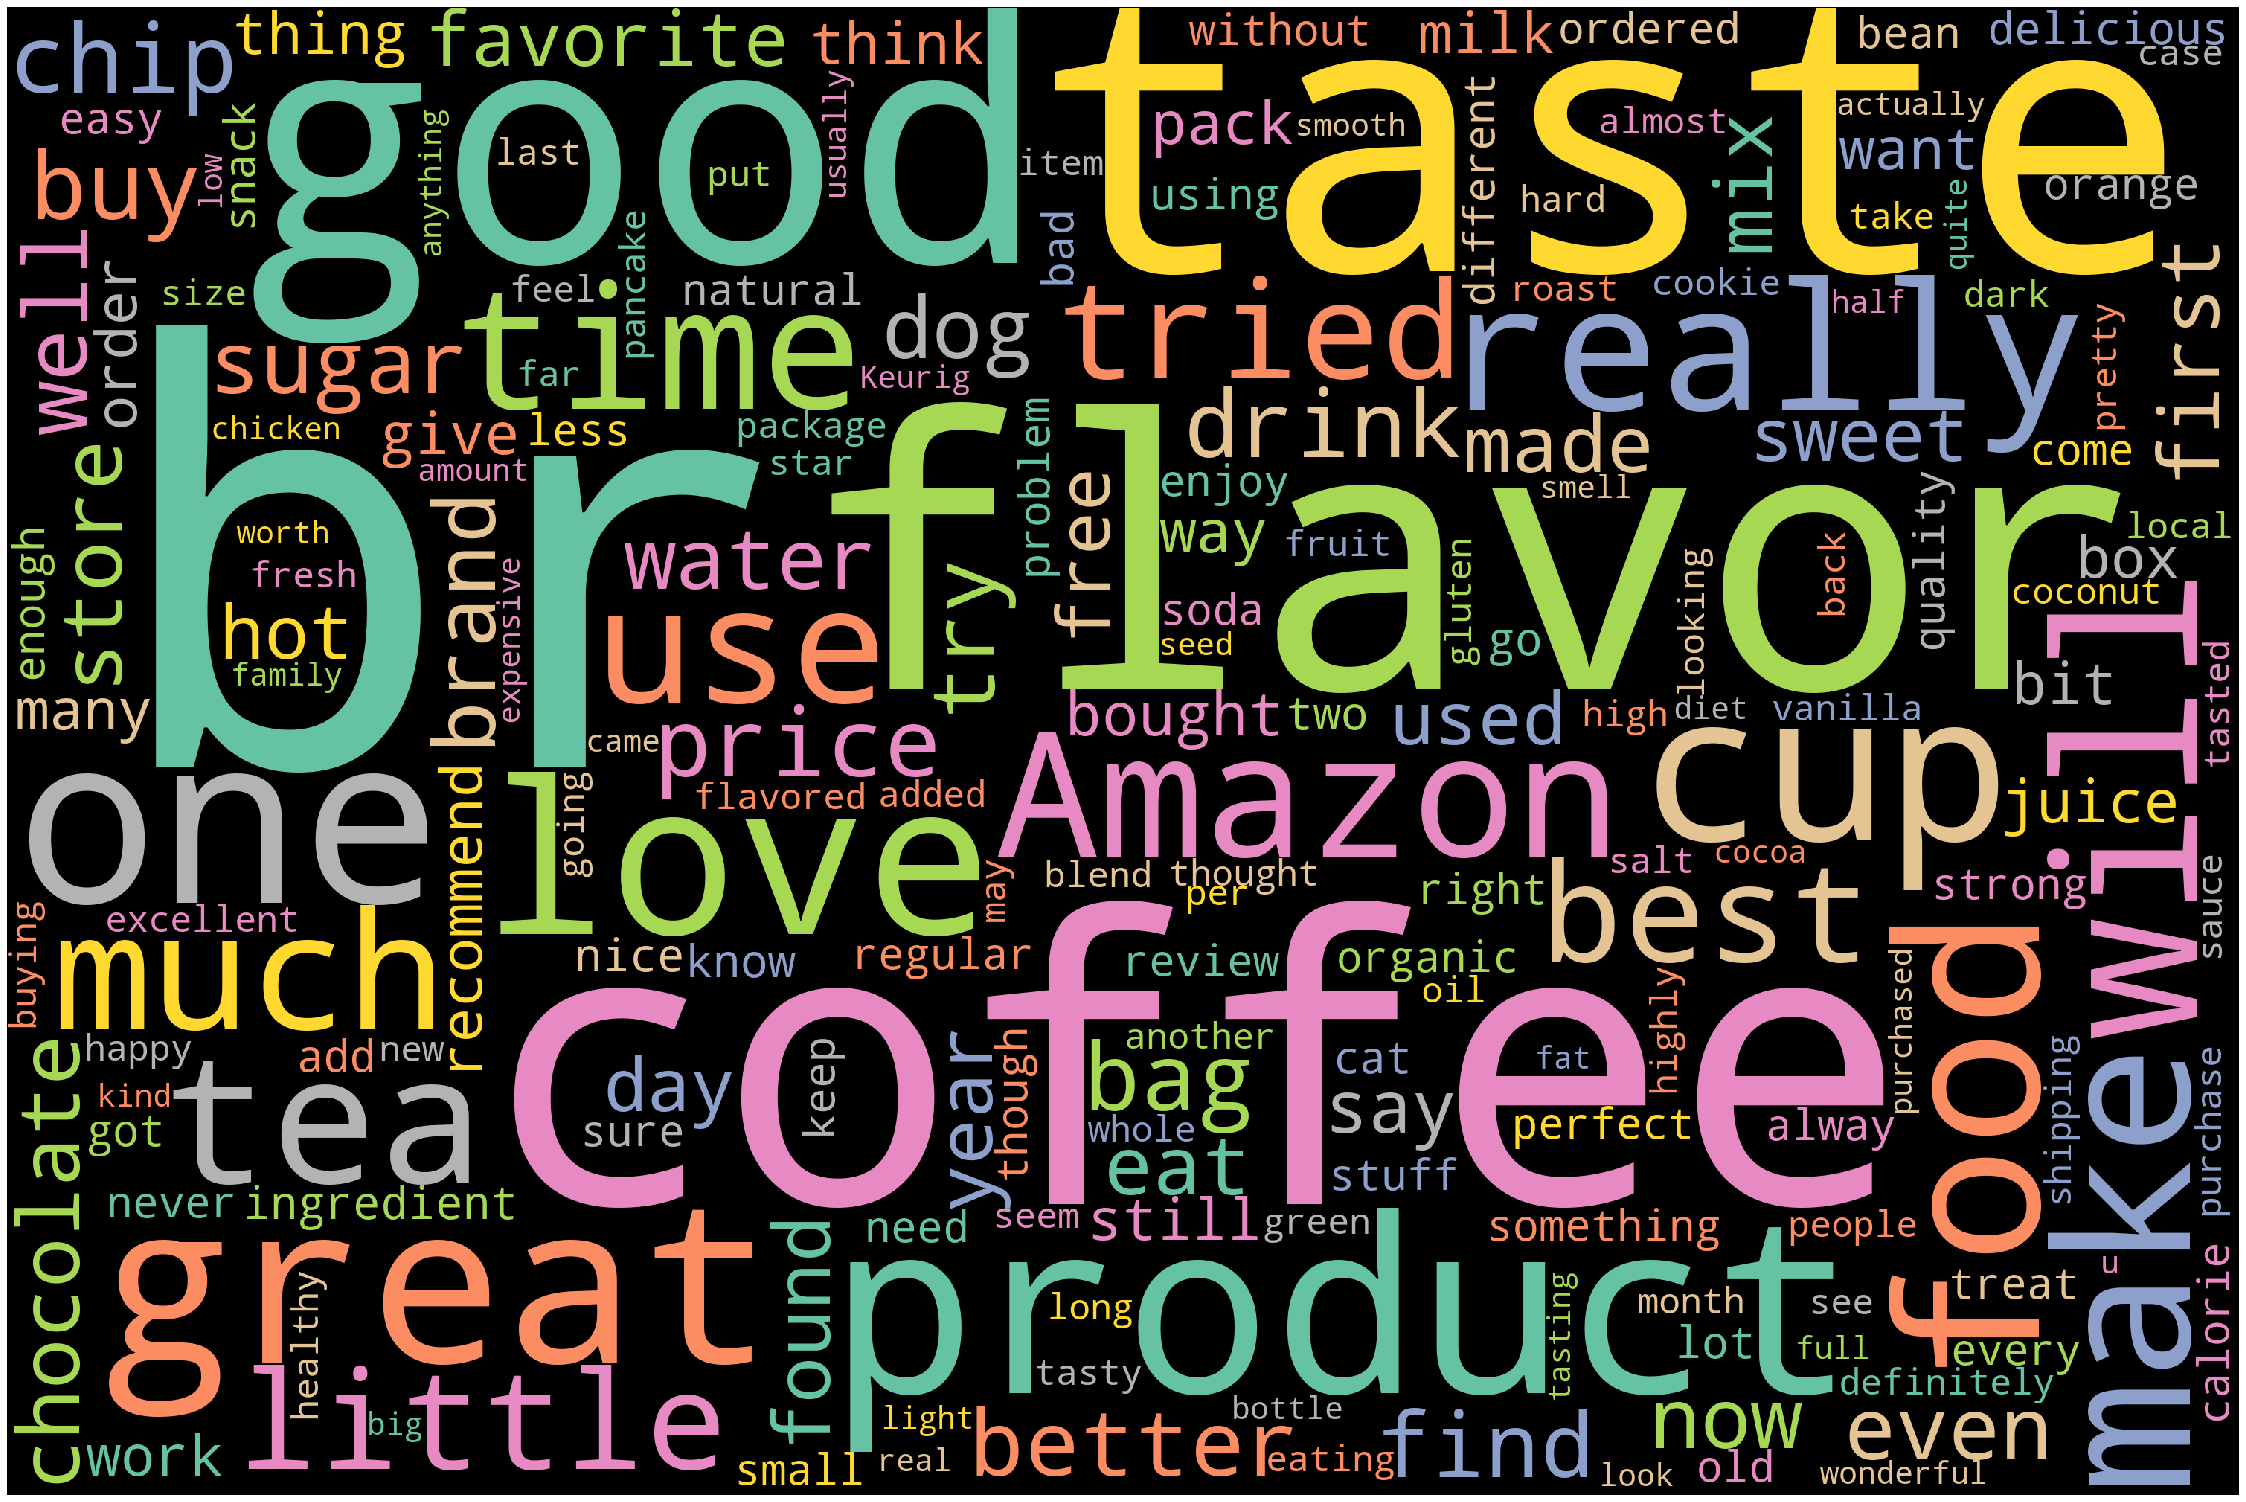

In [8]:
#looking at the distribution of the text.
#words that appear bigger have high frequency in the review.
#words that appear small have low frequency in the review.


# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");


from wordcloud import WordCloud
word_cloud_text = ''.join(df['Text'])


# Generate wordcloud
wordcloud = WordCloud(width = 3000, # width of the canvas
                      height = 2000, # height of the canvas
                      random_state=1, 
                      background_color='black', # background color for the word cloud image
                      colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(word_cloud_text)
# Plot
plot_cloud(wordcloud)

In [9]:
labels = df["labels"]

In [10]:
df.shape

(10000, 10)

In [11]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 8000

In [12]:
# split data into train dataset and test dataset
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [13]:
training_sentences.shape

(8000,)

In [14]:
testing_sentences.shape

(2000,)

In [15]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [16]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [19]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                     validation_split=0.2, batch_size=32, verbose=2)

Epoch 1/100
200/200 - 1s - loss: 0.5578 - accuracy: 0.7750 - val_loss: 0.5665 - val_accuracy: 0.7300
Epoch 2/100
200/200 - 0s - loss: 0.5000 - accuracy: 0.7750 - val_loss: 0.5333 - val_accuracy: 0.7300
Epoch 3/100
200/200 - 1s - loss: 0.4423 - accuracy: 0.7867 - val_loss: 0.4607 - val_accuracy: 0.7656
Epoch 4/100
200/200 - 1s - loss: 0.3447 - accuracy: 0.8462 - val_loss: 0.4098 - val_accuracy: 0.7981
Epoch 5/100
200/200 - 1s - loss: 0.2705 - accuracy: 0.8905 - val_loss: 0.3971 - val_accuracy: 0.8069
Epoch 6/100
200/200 - 1s - loss: 0.2205 - accuracy: 0.9134 - val_loss: 0.4000 - val_accuracy: 0.8194
Epoch 7/100
200/200 - 1s - loss: 0.1839 - accuracy: 0.9323 - val_loss: 0.4142 - val_accuracy: 0.8188
Epoch 8/100
200/200 - 0s - loss: 0.1564 - accuracy: 0.9484 - val_loss: 0.4362 - val_accuracy: 0.8219
Epoch 9/100
200/200 - 0s - loss: 0.1327 - accuracy: 0.9564 - val_loss: 0.4626 - val_accuracy: 0.8225
Epoch 10/100
200/200 - 0s - loss: 0.1139 - accuracy: 0.9634 - val_loss: 0.4820 - val_accura

In [20]:
import os

In [21]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

#     plot_graphs(history, "accuracy")
#     plot_graphs(history, "loss")

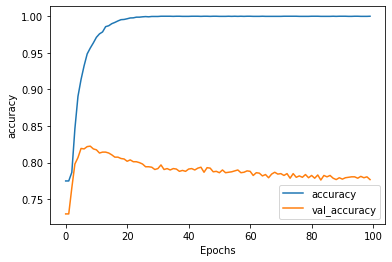

In [22]:
plot_graphs(history, "accuracy")

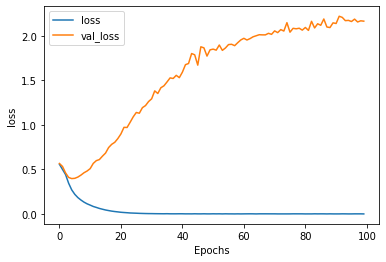

In [23]:
plot_graphs(history, "loss")

In [24]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my <OOV> is finicky and she appreciates this product better than most ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.
1


In [25]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [26]:
sentence = ["Thanks but no thanks, I'm not willing to pay this monthly sum, far too expensive!."]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[1.]]


In [27]:
sentence = ["Don't subscribe to Audible books they are still taking money from my account YEARS after finishing with them. The fraud squad from my bank are forcing them to return money they take every month!"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.00065544]]


In [28]:
sentence = ["I was a previous member but had to cancel unfortunately due to circumstances, and have now signed up again. I prefer to listen to books rather than read them and I love how quick, easy and convenient is to do that on audible, at the touch of a button! I do agree though that the majority of books are way too expensive but bear in mind you get 1 free credit a month, which you can use to purchase any book, no matter the price. You can also swap it in exchange for another anytime, whatever the reason. Sometimes the book turns out to not be what I thought it was, or I can't finish it because that particular narrator's voice grates on me. All in all, I think the price of an audible membership is well worth it, (you also get a 30 day free trial) and would highly recommend. Some older books that I hoped to find are not on there though - please keep adding more and offer a wider selection!"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[2.1729272e-06]]
